In [23]:
import ops
from ops.imports_ipython import *
import pickle 
import glob
import tifffile
from microfilm import microplot
from microfilm.microplot import Micropanel

In [2]:
# Parse function parameters
parse_function_home = "/lab/barcheese01/screens"
parse_function_dataset = "aconcagua"

# Set home directory as a combination of parse_function_home and parse_function_dataset
home = os.path.join(parse_function_home, parse_function_dataset)

# Set number of wells
well_num = 6

# Set number of cycles
cycle_num = 11

# Set test well
test_well = "A1"

# Set test cycle 
test_cycle = "c2"

# Get all SBS TIFF files
sbs_tiff_files = glob.glob(os.path.join(home, "input_sbs_tif", "*.tif"))

# Get all PH TIFF files
ph_tiff_files = glob.glob(os.path.join(home, "input_ph_tif", "*.tif"))

### Check if metadata & file generation went to plan:

In [3]:
# Calculate the total number of expected metadata files
expected_metadata_files = well_num + (cycle_num * well_num)

# Calculate the total number of actual metadata files
metadata_directory = os.path.join(home, "metadata")
metadata_files = [file for file in os.listdir(metadata_directory) if file.endswith('.pkl')]
num_metadata_files = len(metadata_files)

# Split metadata files into 20X (PH) and 10X (SBS) pickle files
metadata_files_ph = [file for file in metadata_files if '20X' in file]
metadata_files_sbs = [file for file in metadata_files if '10X' in file]

# Print the results
print("Expected number of metadata files:", expected_metadata_files)
print("Actual number of metadata files:", num_metadata_files)

Expected number of metadata files: 72
Actual number of metadata files: 72


In [4]:
# Initialize total row count for PH metadata
total_ph_metadata_rows = 0

# Iterate over each 20X (PH) metadata file
for ph_metadata_file in metadata_files_ph:
    # Construct the full file path
    file_path = os.path.join(home, "metadata", ph_metadata_file)
    
    # Open the PKL file in binary mode and load the data
    with open(file_path, 'rb') as file:
        ph_metadata = pickle.load(file)
        
        # Assuming ph_metadata is a pandas DataFrame, add its row count to the total
        total_ph_metadata_rows += len(ph_metadata)

# Print the total row count for PH metadata
print("Total number of metadata rows in all PH files:", total_ph_metadata_rows)

# Count the number of PH TIFF files
num_ph_tiff_files = len(ph_tiff_files)

# Define scaling factor (3 channels for PH images)
scaling_factor = 3  # DAPI-GFP, A594, AF750

# Calculate and print the expected number of metadata entries
expected_ph_metadata_entries = num_ph_tiff_files / scaling_factor
print(f"Expected number of metadata entries (PH TIFF files / scaling factor): {expected_ph_metadata_entries}")

Total number of metadata rows in all PH files: 7686
Expected number of metadata entries (PH TIFF files / scaling factor): 7686.0


In [6]:
# Initialize total row count for SBS metadata
total_sbs_metadata_rows = 0

# Iterate over each 10X (SBS) metadata file
for sbs_metadata_file in metadata_files_sbs:
    # Construct the full file path
    file_path = os.path.join(home, "metadata", sbs_metadata_file)
    
    # Open the PKL file in binary mode and load the data
    with open(file_path, 'rb') as file:
        sbs_metadata = pickle.load(file)
        
        # Assuming sbs_metadata is a pandas DataFrame, add its row count to the total
        total_sbs_metadata_rows += len(sbs_metadata)

# Print the total row count for SBS metadata
print("Total number of metadata rows in all SBS files:", total_sbs_metadata_rows)

# Count the number of SBS TIFF files
num_sbs_tiff_files = len(sbs_tiff_files)

# Calculate scaling factor for SBS
# First cycle has 1 image, subsequent cycles have 4 images
scaling_factor = (1 + (cycle_num-1)*4)/cycle_num

# Calculate and print the expected number of metadata entries
expected_sbs_metadata_entries = num_sbs_tiff_files / scaling_factor
print(f"Expected number of metadata entries (SBS TIFF files / scaling factor): {expected_sbs_metadata_entries}")

Total number of metadata rows in all SBS files: 21978
Expected number of metadata entries (SBS TIFF files / scaling factor): 21978.0


### Generate maps of metadata, and check if initial sites is a logical choice

In [7]:
# Find and load PH metadata for the test well
ph_test_metadata = None
for ph_metadata_file in metadata_files_ph:
    if test_well in ph_metadata_file:
        with open(os.path.join(home, "metadata", ph_metadata_file), 'rb') as f:
            ph_test_metadata = pickle.load(f)
        break

if ph_test_metadata is None:
    print(f"No PH metadata file found for test well {test_well}")

# Find and load SBS metadata for the test well and cycle
sbs_test_metadata = None
for sbs_metadata_file in metadata_files_sbs:
    if test_well in sbs_metadata_file and test_cycle in sbs_metadata_file:
        with open(os.path.join(home, "metadata", sbs_metadata_file), 'rb') as f:
            sbs_test_metadata = pickle.load(f)
        break

if sbs_test_metadata is None:
    print(f"No SBS metadata file found for test well {test_well} and cycle {test_cycle}")

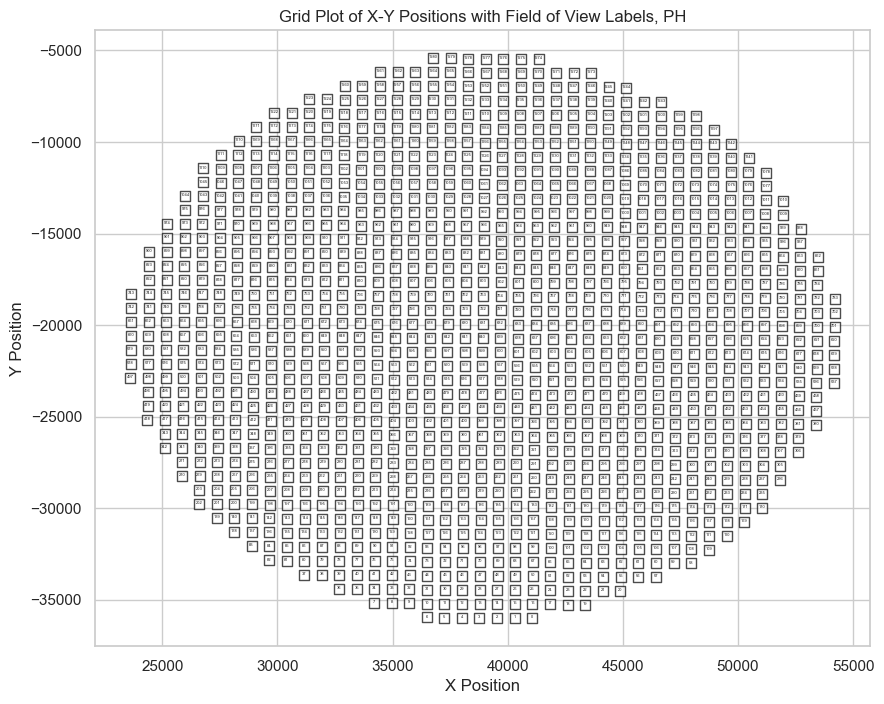

In [12]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Scatter plot with squares for each point
plt.scatter(ph_test_metadata['x_data'], ph_test_metadata['y_data'], 
            s=50, c='white', marker='s', edgecolors='black', 
            linewidths=1, alpha=0.7)

# Label each point with the 'field_of_view' variable
for i, txt in enumerate(ph_test_metadata['field_of_view']):
    plt.annotate(txt, (ph_test_metadata['x_data'].iloc[i], ph_test_metadata['y_data'].iloc[i]), 
                 textcoords="offset points", xytext=(0,0), ha='center', fontsize=3)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Grid Plot of X-Y Positions with Field of View Labels, PH')

# Save the figure as an SVG file
plt.savefig(os.path.join(home, "metadata", 'ph_metadata_example.svg'), format='svg', dpi=1200)
plt.show()

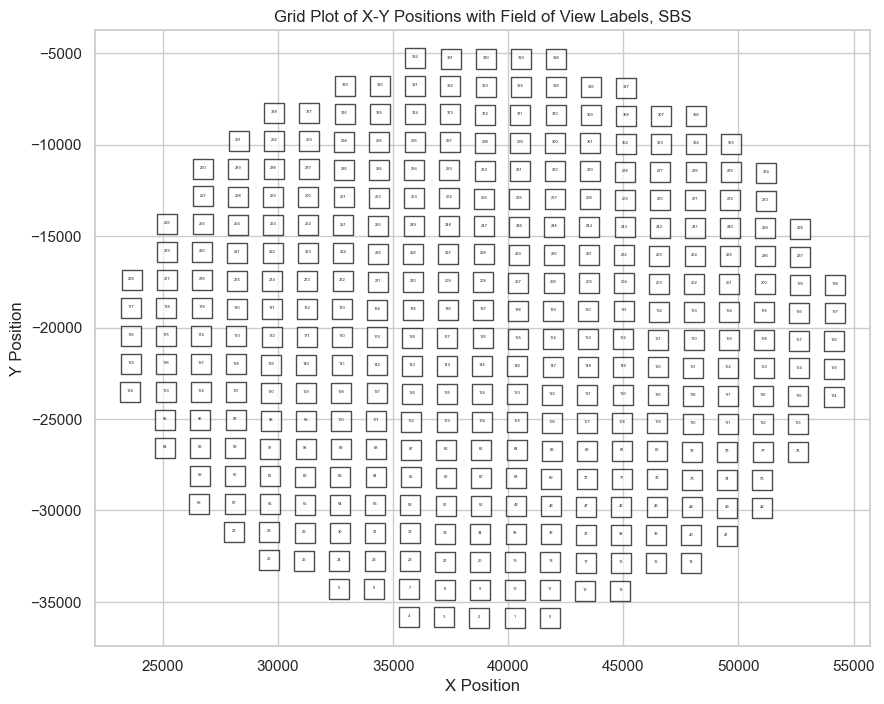

In [13]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Scatter plot with squares for each point
plt.scatter(sbs_test_metadata['x_data'], sbs_test_metadata['y_data'], 
            s=200, c='white', marker='s', edgecolors='black', 
            linewidths=1, alpha=0.7)

# Label each point with the 'field_of_view' variable
for i, txt in enumerate(sbs_test_metadata['field_of_view']):
    plt.annotate(txt, (sbs_test_metadata['x_data'].iloc[i], sbs_test_metadata['y_data'].iloc[i]), 
                 textcoords="offset points", xytext=(0,0), ha='center', fontsize=3)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Grid Plot of X-Y Positions with Field of View Labels, SBS')

# Save the figure as an SVG file
plt.savefig(os.path.join(home, "metadata", 'sbs_metadata_example.svg'), format='svg', dpi=1200)
plt.show()

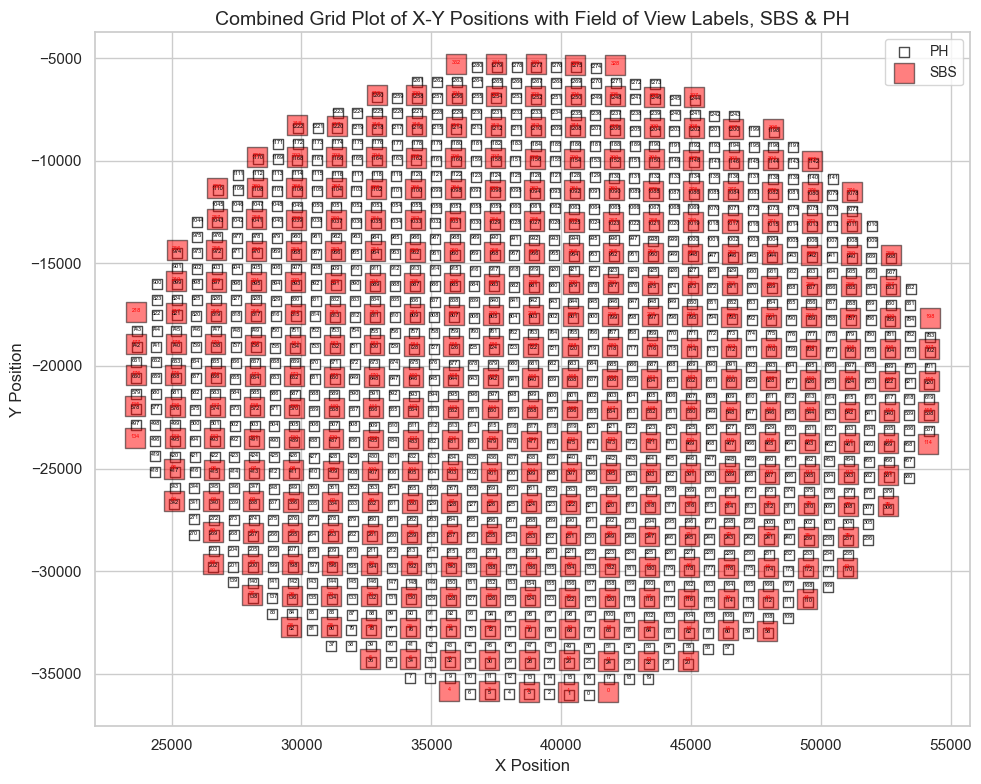

In [15]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Scatter plot for PH data
plt.scatter(ph_test_metadata['x_data'], ph_test_metadata['y_data'], 
            s=50, c='white', marker='s', edgecolors='black', 
            linewidths=1, alpha=0.7, label='PH')

# Label each PH point with the 'field_of_view' variable
for i, txt in enumerate(ph_test_metadata['field_of_view']):
    plt.annotate(txt, (ph_test_metadata['x_data'].iloc[i], ph_test_metadata['y_data'].iloc[i]), 
                 textcoords="offset points", xytext=(0,0), ha='center', fontsize=4, color='black')

# Scatter plot for SBS data
plt.scatter(sbs_test_metadata['x_data'], sbs_test_metadata['y_data'], 
            s=200, c='red', marker='s', edgecolors='black', 
            linewidths=1, alpha=0.5, label='SBS')

# Label each SBS point with the 'field_of_view' variable
for i, txt in enumerate(sbs_test_metadata['field_of_view']):
    plt.annotate(txt, (sbs_test_metadata['x_data'].iloc[i], sbs_test_metadata['y_data'].iloc[i]), 
                 textcoords="offset points", xytext=(0,0), ha='center', fontsize=4, color='red')

# Set labels and title
plt.xlabel('X Position', fontsize=12)
plt.ylabel('Y Position', fontsize=12)
plt.title('Combined Grid Plot of X-Y Positions with Field of View Labels, SBS & PH', fontsize=14)

plt.legend(fontsize=10)
plt.tight_layout()

# Save the figure as an SVG file
plt.savefig(os.path.join(home, "metadata", 'combined_metadata_example.svg'), 
            format='svg', dpi=1200, bbox_inches='tight')
plt.show()

Based on these metadata maps, set 6 initial sites that match up well. We will load images for one of those sites, to ensure that we can visualize cell patterns (using the dapi channel) that correspond between two tiles that will make up our initial sites.

In [17]:
# Set tested matching images
initial_sites = [(1,1),(186,50),(548,150),(656,174),(887,225),(1279,331)]
ph_tiles = [coord[0] for coord in initial_sites]
sbs_tiles = [coord[1] for coord in initial_sites]

In [18]:
# Filter the PH test metadata to include only the specified tiles
filtered_ph_test_metadata = ph_test_metadata[ph_test_metadata['field_of_view'].isin(ph_tiles)]
filtered_ph_test_metadata

x_data   y_data   z_data  pfs_offset  \
1     40299.1 -36010.1  3963.27        9494   
186   38826.9 -29886.1  3960.71        9494   
548   46533.8 -22318.1  3962.32        9494   
656   26690.0 -20610.6  3970.58        9494   
887   34369.3 -16096.9  3970.29        9494   
1279  37521.2  -5432.3  3977.88        9494   

                                               filename  field_of_view  
1     /lab/barcheese01/screens/aconcagua/input_ph/DA...              1  
186   /lab/barcheese01/screens/aconcagua/input_ph/DA...            186  
548   /lab/barcheese01/screens/aconcagua/input_ph/DA...            548  
656   /lab/barcheese01/screens/aconcagua/input_ph/DA...            656  
887   /lab/barcheese01/screens/aconcagua/input_ph/DA...            887  
1279  /lab/barcheese01/screens/aconcagua/input_ph/DA...           1279

In [19]:
# Filter the SBS test metadata to include only the specified tiles
filtered_sbs_test_metadata = sbs_test_metadata[sbs_test_metadata['field_of_view'].isin(sbs_tiles)]
filtered_sbs_test_metadata

x_data   y_data   z_data  pfs_offset  \
1    40275.8 -35875.6  3131.96        7135   
50   38803.8 -29751.7  3129.57        7135   
150  46510.6 -22183.3  3131.69        7135   
174  26667.0 -20475.5  3128.74        7135   
225  34346.2 -15962.5  3131.06        7135   
331  37498.1  -5297.9  3146.07        7135   

                                              filename  field_of_view  
1    /lab/barcheese01/screens/aconcagua/input_sbs/c...              1  
50   /lab/barcheese01/screens/aconcagua/input_sbs/c...             50  
150  /lab/barcheese01/screens/aconcagua/input_sbs/c...            150  
174  /lab/barcheese01/screens/aconcagua/input_sbs/c...            174  
225  /lab/barcheese01/screens/aconcagua/input_sbs/c...            225  
331  /lab/barcheese01/screens/aconcagua/input_sbs/c...            331

### Load single sbs images

In [24]:
# Find and load a specific SBS image for the test cycle
sbs_test_cycle_image = None
for file_path in sbs_tiff_files:
    # Check if the file matches the criteria: test_well, test_cycle, CY3 channel, and specific tile
    if all(substring in file_path for substring in [test_well, test_cycle, 'CY3_30p', f"Tile-{sbs_tiles[0]}.sbs"]):
        print(f"SBS test cycle image file path: {file_path}")
        # Read the multi-page TIFF image
        sbs_test_cycle_image = tifffile.imread(file_path)
        print(f"SBS test cycle image shape: {sbs_test_cycle_image.shape}")
        break

# Find and load a specific SBS image for cycle 1
sbs_cycle1_multichannel_image = None
for file_path in sbs_tiff_files:
    # Check if the file matches the criteria: test_well, cycle 1, multi-channel, and specific tile
    if all(substring in file_path for substring in [test_well, 'c1', 'DAPI-CY3_30p_545-A594_30p-CY5_30p-CY7_30p', f"Tile-{sbs_tiles[0]}.sbs"]):
        print(f"SBS cycle 1 multichannel image file path: {file_path}")
        # Read the multi-page TIFF image
        sbs_cycle1_multichannel_image = tifffile.imread(file_path)
        print(f"SBS cycle 1 multichannel image shape: {sbs_cycle1_multichannel_image.shape}")
        break

SBS test cycle image file path: /lab/barcheese01/screens/aconcagua/input_sbs_tif/10X_c2-SBS-2_A1_Tile-1.sbs.Channel-CY3_30p_545.tif
SBS test cycle image shape: (1480, 1480)
SBS cycle 1 multichannel image file path: /lab/barcheese01/screens/aconcagua/input_sbs_tif/10X_c1-SBS-1_A1_Tile-1.sbs.Channel-DAPI-CY3_30p_545-A594_30p-CY5_30p-CY7_30p.tif
SBS cycle 1 multichannel image shape: (5, 1480, 1480)


#### Check if cycle 1 looks good

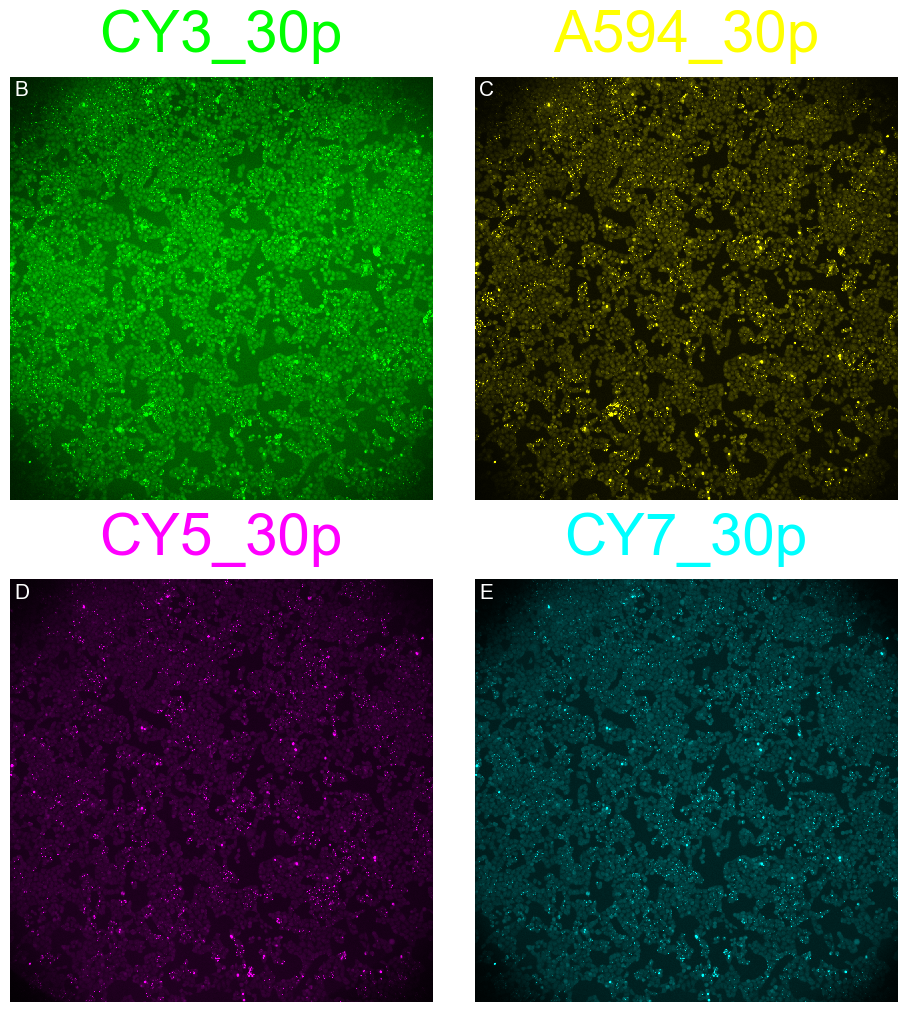

In [25]:
# Define channel order and colors for SBS images
channel_order_sbs = ['DAPI', 'CY3_30p', 'A594_30p', 'CY5_30p', 'CY7_30p']
cmaps = ['pure_blue', 'pure_green', 'pure_yellow', 'pure_magenta', 'pure_cyan']
DISPLAY_RANGES = [
    [500, 7500],
    [100, 10000],
    [100, 10000],
    [200, 25000],
    [200, 25000]
]

# Create microshow plots for each channel with specified colormaps and display ranges
microim0_sbs = microplot.Microimage(sbs_cycle1_multichannel_image[0], 
                                    rescale_type='limits',
                                    limits=DISPLAY_RANGES[0],
                                    label_text='A', 
                                    channel_names=channel_order_sbs[0],
                                    unit='um', scalebar_unit_per_pix=0.065, scalebar_size_in_units=10,
                                    scalebar_font_size=15, scalebar_thickness=0.02)

microim1_sbs = microplot.Microimage(sbs_cycle1_multichannel_image[1],
                                    cmaps=cmaps[1],
                                    rescale_type='limits',
                                    limits=DISPLAY_RANGES[1],
                                    label_text='B',
                                    channel_names=channel_order_sbs[1])

microim2_sbs = microplot.Microimage(sbs_cycle1_multichannel_image[2],
                                    cmaps=cmaps[2],
                                    rescale_type='limits', 
                                    limits=DISPLAY_RANGES[2],
                                    label_text='C',
                                    channel_names=channel_order_sbs[2])

microim3_sbs = microplot.Microimage(sbs_cycle1_multichannel_image[3],
                                    cmaps=cmaps[3], 
                                    rescale_type='limits', 
                                    limits=DISPLAY_RANGES[3],
                                    label_text='D',
                                    channel_names=channel_order_sbs[3])

microim4_sbs = microplot.Microimage(sbs_cycle1_multichannel_image[4],
                                    cmaps=cmaps[4], 
                                    rescale_type='limits',
                                    limits=DISPLAY_RANGES[4], 
                                    label_text='E',
                                    channel_names=channel_order_sbs[4])

# Create a panel to display the images
panel = Micropanel(rows=2, cols=2, figscaling=5)
panel.add_element([0,0], microim1_sbs)
panel.add_element([0,1], microim2_sbs)
panel.add_element([1,0], microim3_sbs)
panel.add_element([1,1], microim4_sbs)
panel.add_channel_label()

#### Check if subsequent cycles match up with DAPI in cycle 1

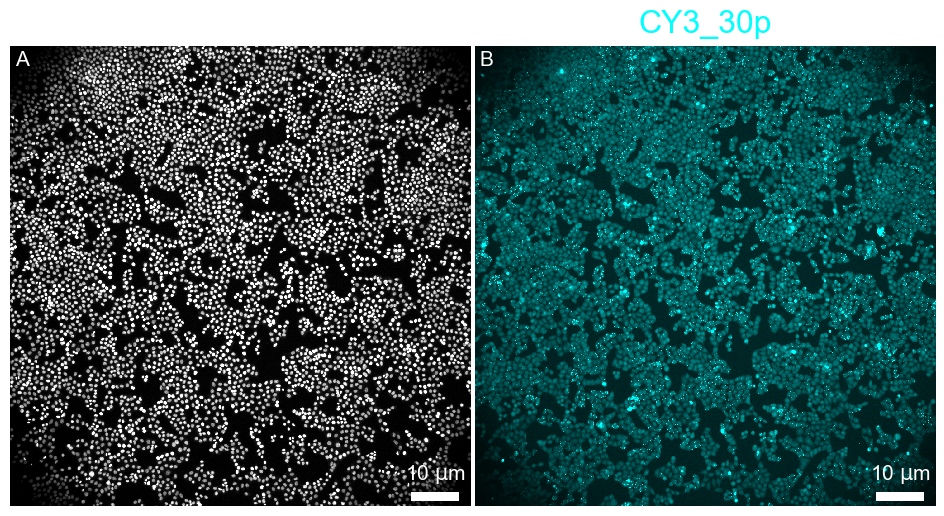

In [26]:
# Create a Microimage for the single-channel SBS image from the test cycle
microim1_sbs_single = microplot.Microimage(sbs_test_cycle_image,
                                           cmaps='pure_cyan', 
                                           rescale_type='limits',
                                           limits=DISPLAY_RANGES[1],
                                           label_text='B', 
                                           channel_names=channel_order_sbs[1],
                                           unit='um', scalebar_unit_per_pix=0.065, scalebar_size_in_units=10,
                                           scalebar_font_size=15, scalebar_thickness=0.02)

# Create a panel to display the images side by side
panel = Micropanel(rows=1, cols=2, figscaling=5)
panel.add_element([0,0], microim0_sbs)
panel.add_element([0,1], microim1_sbs_single)
panel.add_channel_label()

In [27]:
# Find and load the DAPI channel PH (Phase) image
ph_image_dapi = None
for file_path in ph_tiff_files:
    if all(substring in file_path for substring in [test_well, 'DAPI_1x1', f"Tile-{ph_tiles[0]}.ph"]):
        print(f"PH DAPI image file path: {file_path}")
        ph_image_dapi = tifffile.imread(file_path)
        print(f"PH DAPI image shape: {ph_image_dapi.shape}")
        break

# Find and load the A594 channel PH image
ph_image_a594 = None
for file_path in ph_tiff_files:
    if all(substring in file_path for substring in [test_well, 'A594_1x1', f"Tile-{ph_tiles[0]}.ph"]):
        print(f"PH A594 image file path: {file_path}")
        ph_image_a594 = tifffile.imread(file_path)
        print(f"PH A594 image shape: {ph_image_a594.shape}")
        break

PH DAPI image file path: /lab/barcheese01/screens/aconcagua/input_ph_tif/20X_A1_Tile-1.phenotype.Channel-DAPI_1x1-GFP_1x1.tif
PH DAPI image shape: (2, 2960, 2960)
PH A594 image file path: /lab/barcheese01/screens/aconcagua/input_ph_tif/20X_A1_Tile-1.phenotype.Channel-A594_1x1.tif
PH A594 image shape: (2960, 2960)


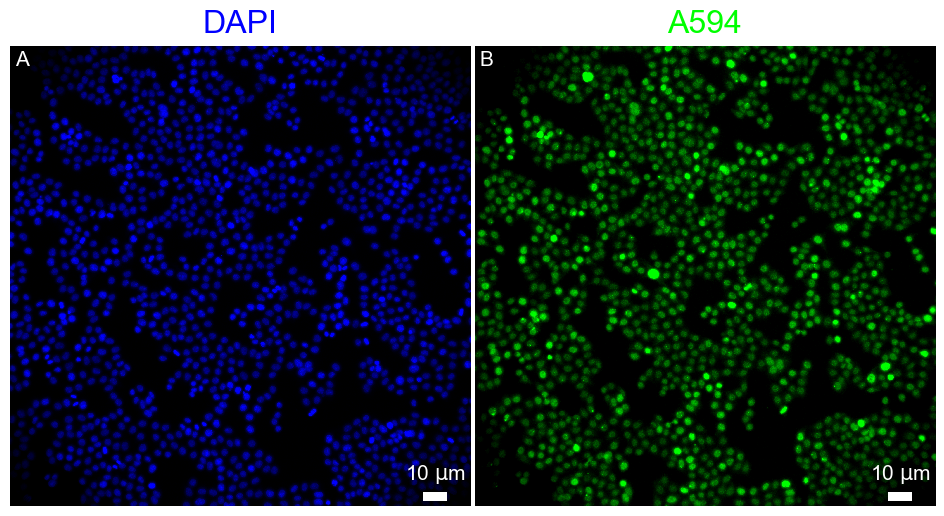

In [28]:
# Set channel order for PH images
channel_order_ph = ['DAPI', 'A594']

# Define custom display ranges for each channel
DISPLAY_RANGES_PH = [
    [500, 10000],
    [800, 5000],
]

# Create Microimage for DAPI channel
microim_ph_dapi = microplot.Microimage(ph_image_dapi[0],
                                       cmaps='pure_blue', 
                                       rescale_type='limits', 
                                       limits=DISPLAY_RANGES_PH[0],
                                       label_text='A', 
                                       channel_names=channel_order_ph[0],
                                       unit='um', scalebar_unit_per_pix=0.065, scalebar_size_in_units=10,
                                       scalebar_font_size=15, scalebar_thickness=0.02)

# Create Microimage for A594 channel
microim_ph_a594 = microplot.Microimage(ph_image_a594,
                                       cmaps='pure_green', 
                                       rescale_type='limits',
                                       limits=DISPLAY_RANGES_PH[1],
                                       label_text='B', 
                                       channel_names=channel_order_ph[1],
                                       unit='um', scalebar_unit_per_pix=0.065, scalebar_size_in_units=10,
                                       scalebar_font_size=15, scalebar_thickness=0.02)

# Create panel to display both images
panel = Micropanel(rows=1, cols=2, figscaling=5)
panel.add_element([0,0], microim_ph_dapi)
panel.add_element([0,1], microim_ph_a594)
panel.add_channel_label()

### Check if sbs and ph match for one matched site

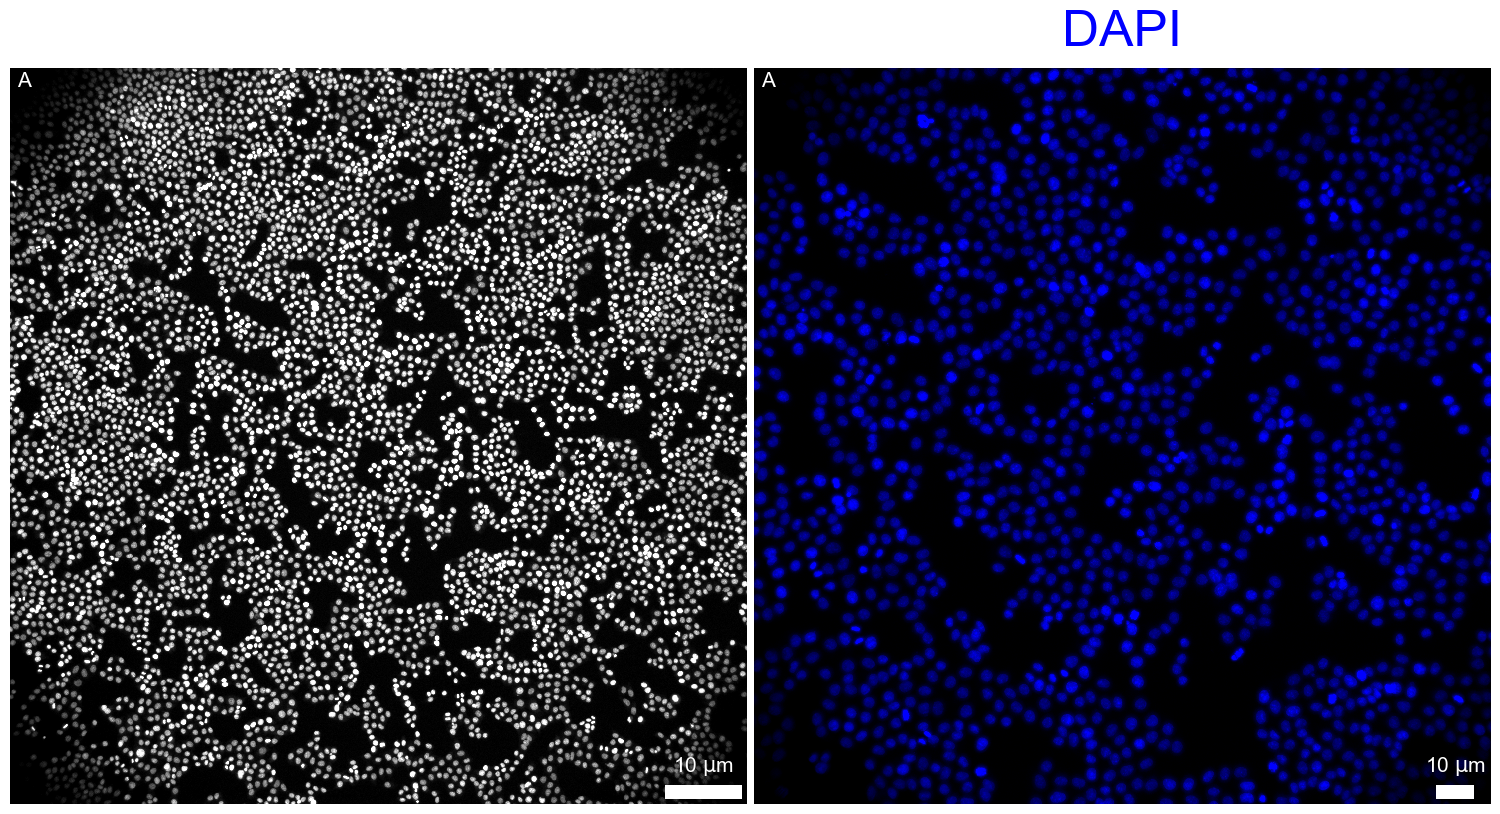

In [29]:
# Create a panel to compare DAPI images from SBS and PH
panel_dapi_merged = Micropanel(rows=1, cols=2, figscaling=8)
panel_dapi_merged.add_element([0,0], microim0_sbs)
panel_dapi_merged.add_element([0,1], microim_ph_dapi)
panel_dapi_merged.add_channel_label()